In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
from keras import backend as K
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed
from keras.layers import Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import brown
from sklearn.model_selection import train_test_split, KFold

In [ ]:
import codecs
import pickle
import numpy as np
import pandas as pd

In [ ]:


#Downloading Glove Word Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip



--2022-11-28 09:24:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-28 09:24:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-28 09:24:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
f = codecs.open("corpus1.txt", "r", encoding="utf8")

data = f.readlines()

f.close()

In [ ]:
l=[]
for i in range(len(data)):
  if (data[i][0].strip()):
    l.append(tuple(''.join(data[i]).split()))
l[:10]
len(l)

4949

In [ ]:
#separating sentences and tags as separate sequences
sentences, sentence_tags =[], []
for tagged_sentence in l:
  if(len(tagged_sentence)<2):
    print(tagged_sentence)
  sentences.append(tagged_sentence[0])
  sentence_tags.append(tagged_sentence[1])

In [ ]:
#Function to ignore the 0 padding while calculating accuracy
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)

        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

#Function to return one code encoding of tags
def one_hot_encoding(tag_sents, n_tags):
    tag_one_hot_sent = []
    for tag_sent in tag_sents:
        tags_one_hot = []
        for tag in tag_sent:
            tags_one_hot.append(np.zeros(n_tags))
            tags_one_hot[-1][tag] = 1.0
        tag_one_hot_sent.append(tags_one_hot)
    return np.array(tag_one_hot_sent)

#Function to convert output into tags
def logits_to_tags(tag_sentences, index):
    tag_sequences = []
    for tag_sentence in tag_sentences:
        tag_sequence = []
        for tag in tag_sentence:
            # if index[np.argmax(tag)] == "-PAD-":
            #     break
            # else:
                tag_sequence.append(index[np.argmax(tag)])
        tag_sequences.append(np.array(tag_sequence))
    return tag_sequences

In [ ]:
#Use the 300 dimensional GLove Word Embeddings
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open('/content/glove.6B.300d.txt','rb')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
acc = []
conf_matrix = []
precision_fold = []
accuracy_fold = []
recall_fold = []
f1score_fold = []

tag_list=['CC', 'DEM', 'DET', 'INJ', 'IRR', 'JJ', 'NN', 'NUM', 'PRP', 'PSP',
       'QC', 'RB', 'SYM', 'UT', 'VM', 'WQ']

# The integers for each tag are the same as above

MAX_LENGTH = len(max(sentences, key=len)) # maximum words in a sentence

conf_mat_df = pd.DataFrame(columns=tag_list, index=tag_list)
conf_mat_df = conf_mat_df.fillna(0)

In [ ]:
num_folds = 5
iteration = 1
kfold = KFold(num_folds)

for train_index, test_index in kfold.split(range(len(data))):

    print("Iteration " + str(iteration) + " started.")
    train_sentences = np.take(sentences,train_index).tolist()
    test_sentences = np.take(sentences,test_index).tolist()
    train_tags = np.take(sentence_tags,train_index).tolist()
    test_tags = np.take(sentence_tags,test_index).tolist()

    true_pos_tag = defaultdict(int)
    false_pos_tag = defaultdict(int)
    false_neg_tag = defaultdict(int)
    precision_tags = defaultdict(float)
    accuracy_tags = defaultdict(float)
    recall_tags = defaultdict(float)
    f1score_tags = defaultdict(float)

    words, tags = set([]), set([])
    #creating sets of words and tags
    for sentence in train_sentences:
        for word in sentence:
            words.add(word.lower())

    for tag_sent in train_tags:
        for tag in tag_sent:
            tags.add(tag)

    #bulding vocabulary of words and tags
    word2index = {word: i + 2 for i, word in enumerate(list(words))}
    word2index['-PAD-'] = 0  # 0 is assigned for padding
    word2index['-OOV-'] = 1  # 1 is assigned for unknown words
    tag2index = {tag: i + 1 for i, tag in enumerate(list(tags))}
    tag2index['-PAD-'] = 0  # 0 is assigned for padding

    #Tokenising words and  by their indexes in vocabulary
    train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

    for sentence in train_sentences:
        sent_int = []
        for word in sentence:
            try:
                sent_int.append(word2index[word.lower()])
            except KeyError:
                sent_int.append(word2index['-OOV-'])
        train_sentences_X.append(sent_int)

    for sentence in test_sentences:
        sent_int = []
        for word in sentence:
            try:
                sent_int.append(word2index[word.lower()])
            except KeyError:
                sent_int.append(word2index['-OOV-'])
        test_sentences_X.append(sent_int)

    for sent_tags in train_tags:
        train_tags_y.append([tag2index[tag] for tag in sent_tags])

    for sent_tags in test_tags:
        test_tags_y.append([tag2index[tag] for tag in sent_tags])

    #Add padding to sentences
    train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
    test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
    train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
    test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

    #Building the Embedding Layer
    embedding_dim = 300

    embedding_matrix = np.zeros((len(word2index), embedding_dim))
    for word, i in word2index.items():
        embedding_vector = embeddings_index.get(word)
        if i < len(word2index):
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

    #Building the BiLSTM model
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_LENGTH, )))
    model.add(Embedding(len(word2index), 300, weights=[embedding_matrix],trainable=False))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(len(tag2index))))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),
                  metrics=['accuracy', ignore_class_accuracy(0)])
    model.summary()
    one_hot_train_tags_y = one_hot_encoding(train_tags_y, len(tag2index))

    #Training the model
    history = model.fit(train_sentences_X, one_hot_encoding(train_tags_y, len(tag2index)),
              batch_size=128, epochs= 9, validation_split=0.2)

    scores = model.evaluate(test_sentences_X, one_hot_encoding(test_tags_y, len(tag2index)))
    acc.append(scores[1]*100)


    predictions = model.predict(test_sentences_X)
    pred_sequence = logits_to_tags(predictions, {i: t for t, i in tag2index.items()})
    y_prob_class = (model.predict(test_sentences_X, verbose = 1))>0.5
    try:
      for sen_num in range(len(test_tags)):
          for i,tag in enumerate(test_tags[sen_num]):
              conf_mat_df[tag][pred_sequence[sen_num][i]] +=1
              if test_tags[sen_num][i] == pred_sequence[sen_num][i]:
                true_pos_tag[tag] += 1
              else:
                false_neg_tag[tag] += 1
                false_pos_tag[pred_sequence[sen_num][i]] += 1
    except:
      continue

    for tag in tag_list[1:]:
        precision_tags[tag] = true_pos_tag[tag] / (true_pos_tag[tag] + false_pos_tag[tag])
        recall_tags[tag] = true_pos_tag[tag] / (true_pos_tag[tag] + false_neg_tag[tag])
        f1score_tags[tag] = 2 * precision_tags[tag] * recall_tags[tag] / (precision_tags[tag] + recall_tags[tag])
        accuracy_tags[tag] = true_pos_tag[tag] / (true_pos_tag[tag] + false_neg_tag[tag] + false_pos_tag[tag])

    #conf_matrix.append(conf_mat_df)
    accuracy_fold.append(accuracy_tags)
    precision_fold.append(precision_tags)
    recall_fold.append(recall_tags)
    f1score_fold.append(f1score_tags)
    if iteration == 1:
        break
    iteration += 1


Iteration 1 started.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 26, 300)           25200     
                                                                 
 bidirectional_10 (Bidirecti  (None, 26, 512)          1140736   
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 26, 18)           9234      
 stributed)                                                      
                                                                 
 activation_10 (Activation)  (None, 26, 18)            0         
                                                                 
Total params: 1,175,170
Trainable params: 1,149,970
Non-trainable params: 25,200
_________________________________________________________________
Epoch 1/9
25/25 [

In [ ]:
predictions[0][2]

array([6.1688215e-01, 5.6874678e-03, 8.4197540e-03, 6.2089264e-03,
       2.4051750e-02, 5.1395368e-04, 5.0833328e-03, 2.1947069e-02,
       3.2019755e-03, 4.8227571e-03, 6.8808859e-03, 1.1516171e-02,
       1.2490945e-02, 5.6410879e-03, 6.2327515e-03, 6.3348472e-02,
       2.9840809e-04, 1.9677216e-01], dtype=float32)

In [ ]:
tot_acc = np.mean(acc)
tot_acc

74.00615970293681

In [ ]:
acc

[48.571908473968506,
 35.9106183052063,
 28.286290168762207,
 30.517473816871643,
 29.1973739862442,
 95.21756172180176,
 93.95493268966675,
 93.0924654006958,
 93.30225586891174,
 93.23714971542358,
 95.21756172180176,
 93.95493268966675,
 93.0924654006958,
 93.30225586891174,
 93.23714971542358]

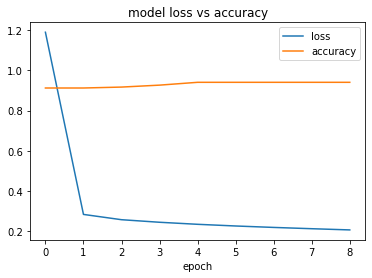

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()
